In [ ]:
import pandas as pd

# Load the data and rename columns for clarity and to fix encoding
df = pd.read_csv('cfn_volumencreditocontingente_2025_enero-septiembre.csv', delimiter=';', encoding='latin-1')

new_columns = {
    'FECHA': 'fecha',
    'SUBSISTEMA': 'subsistema',
    'ENTIDAD': 'entidad',
    'TIPO DE CREDITO': 'tipo_de_credito',
    'TIPO DE OPERACION': 'tipo_de_operacion',
    'ESTADO DE LA OPERACION': 'estado_de_la_operacion',
    'PROVINCIA': 'provincia',
    'CANTON': 'canton',
    'SECTOR': 'sector',
    'SUBSECTOR': 'subsector',
    'ACTIVIDAD': 'actividad',
    'NÚMERO DE OPERACIONES': 'numero_de_operaciones',
    'MONTO OTORGADO': 'monto_otorgado'
}
df = df.rename(columns=new_columns)

# --- Data Cleaning and Type Conversion ---

# 1. Date Correction: Handle mixed DD/MM/YYYY and MM/DD/YYYY formats
original_fecha = df['fecha'].copy()
df['fecha'] = pd.to_datetime(df['fecha'], format='%d/%m/%Y', errors='coerce')
na_mask = df['fecha'].isna()
df.loc[na_mask, 'fecha'] = pd.to_datetime(original_fecha[na_mask], format='%m/%d/%Y', errors='coerce')

# 2. Sector Cleaning: Standardize common categories
agricultura_standard = 'AGRICULTURA, GANADERÍA, SILVICULTURA Y PESCA'
comercio_standard = 'COMERCIO AL POR MAYOR Y AL POR MENOR; REPARACIÓN DE VEHÍCULOS AUTOMOTORES Y MOTOCICLETAS'
df['sector'] = df['sector'].str.replace(r'AGRICULTURA.*SILVICULTURA Y PESCA', agricultura_standard, regex=True)
df['sector'] = df['sector'].str.replace(r'COMERCIO AL POR MAYOR Y AL POR MENOR.*MOTOCICLETAS', comercio_standard, regex=True)

# --- Descriptive Statistics and Aggregations ---

# Descriptive statistics for numerical columns
print("Descriptive statistics for numerical columns:")
print(df[['numero_de_operaciones', 'monto_otorgado']].describe().to_markdown(numalign='left', stralign='left'))

# Value counts for key categorical columns
categorical_cols = ['tipo_de_credito', 'tipo_de_operacion', 'estado_de_la_operacion', 'provincia']
for col in categorical_cols:
    print(f"\nValue Counts for '{col}' (Top 10):")
    counts = df[col].value_counts(normalize=True).head(10) * 100
    print(counts.to_frame(name='Percentage').reset_index().to_markdown(numalign='left', stralign='left'))

# Total Monto Otorgado by Cleaned Sector
sector_monto = df.groupby('sector')['monto_otorgado'].sum().sort_values(ascending=False).reset_index()
sector_monto['monto_otorgado'] = sector_monto['monto_otorgado'].round(2)
print("\nTotal Monto Otorgado by Cleaned Sector (Top 10):")
print(sector_monto.head(10).to_markdown(index=False, numalign='left', stralign='left'))

# Total Monto Otorgado by Tipo de Credito
tipo_credito_monto = df.groupby('tipo_de_credito')['monto_otorgado'].sum().sort_values(ascending=False).reset_index()
tipo_credito_monto['monto_otorgado'] = tipo_credito_monto['monto_otorgado'].round(2)
print("\nTotal Monto Otorgado by Tipo de Credito:")
print(tipo_credito_monto.to_markdown(index=False, numalign='left', stralign='left'))

Descriptive statistics for numerical columns:
|       | numero_de_operaciones   | monto_otorgado   |
|:------|:------------------------|:-----------------|
| count | 546                     | 546              |
| mean  | 2.12454                 | 2.18255e+06      |
| std   | 6.84635                 | 8.1137e+06       |
| min   | 1                       | 2553.27          |
| 25%   | 1                       | 55491.7          |
| 50%   | 1                       | 240018           |
| 75%   | 1                       | 957629           |
| max   | 83                      | 1e+08            |

Value Counts for 'tipo_de_credito' (Top 10):
|    | tipo_de_credito                      | Percentage   |
|:---|:-------------------------------------|:-------------|
| 0  | PRODUCTIVO PYMES                     | 43.4066      |
| 1  | PRODUCTIVO CORPORATIVO               | 22.1612      |
| 2  | PRODUCTIVO EMPRESARIAL               | 20.696       |
| 3  | MICROCREDITO DE ACUMULACION AMPLIADA | 13.7363

In [ ]:
import re
import statsmodels.api as sm

# Date Correction: Handle mixed DD/MM/YYYY and MM/DD/YYYY formats
original_fecha = df['fecha'].copy()
df['fecha'] = pd.to_datetime(df['fecha'], format='%d/%m/%Y', errors='coerce')
na_mask = df['fecha'].isna()
df.loc[na_mask, 'fecha'] = pd.to_datetime(original_fecha[na_mask], format='%m/%d/%Y', errors='coerce')


# 2. Final Categorical Cleaning (Encoding and Consolidation)
def clean_string_encoding(text):
    """Function to correct common ISO-8859-1 encoding issues."""
    if isinstance(text, str):
        # Fix tildes (tilde, grave, acute, etc.) - Best effort to handle common Latin-1 issues
        text = text.replace('Ã‘', 'Ñ').replace('Ã‘', 'Ñ')
        text = text.replace('Ã¡', 'á').replace('Ã©', 'é').replace('Ã­', 'í').replace('Ã³', 'ó').replace('Ãº', 'ú')
        text = text.replace('Ã', 'Á').replace('Ã‰', 'É').replace('Ã', 'Í').replace('Ã“', 'Ó').replace('Ãš', 'Ú')
        text = text.replace('Ã±', 'ñ')
        text = text.replace('Ã', 'í') # Catch-all for some 'í' errors
        text = text.replace('Ã’', 'Ó')
        # Specific fixes from inspection
        text = text.replace('Ã\x92', 'Ó')
        text = text.replace('Ã\xad', 'í')
        text = text.replace('Ã\x93', 'Ó')
        text = text.replace('Ã\x91', 'Ñ')
        text = text.replace('Ã\x8d', 'Í')
    return text

# Apply general cleaning to all object columns
for col in df.select_dtypes(include=['object']).columns:
    df[col] = df[col].apply(clean_string_encoding)

# Standardize 'AGRICULTURA' and 'COMERCIO' to consolidate previous issues
agricultura_standard = 'AGRICULTURA, GANADERÍA, SILVICULTURA Y PESCA'
comercio_standard = 'COMERCIO AL POR MAYOR Y AL POR MENOR; REPARACIÓN DE VEHÍCULOS AUTOMOTORES Y MOTOCICLETAS'
df['sector'] = df['sector'].str.replace(r'AGRICULTURA.*SILVICULTURA Y PESCA', agricultura_standard, regex=True)
df['sector'] = df['sector'].str.replace(r'COMERCIO AL POR MAYOR Y AL POR MENOR.*MOTOCICLETAS', comercio_standard, regex=True)


# 3. Data Preparation for GLM
# Target variable: Monto Otorgado (must be strictly positive for Gamma)
# Check for non-positive values (although it's unlikely for a credit volume)
if (df['monto_otorgado'] <= 0).any():
    print("Warning: Non-positive values found in 'monto_otorgado'. Applying small shift for Gamma GLM.")
    df['monto_otorgado'] = df['monto_otorgado'].apply(lambda x: x if x > 0 else 1e-6) # Shift or handle as necessary

y = df['monto_otorgado']

# Explanatory variables
features = ['tipo_de_credito', 'tipo_de_operacion', 'estado_de_la_operacion', 'provincia', 'sector', 'numero_de_operaciones']
X_data = df[features]

# Create dummy variables for categorical features
X = pd.get_dummies(X_data, drop_first=True, columns=['tipo_de_credito', 'tipo_de_operacion', 'estado_de_la_operacion', 'provincia', 'sector'])

# Add a constant for the intercept
X = sm.add_constant(X, prepend=True)

# Save the design matrix to a CSV for user reference and inspection (optional for GLM, but good practice)
X.head().to_csv('glm_design_matrix_head.csv', index=False)
print("Design Matrix (X) Head:")
print(X.head().to_markdown(numalign='left', stralign='left'))

# Check the shape of the design matrix
print(f"\nShape of the design matrix X: {X.shape}")

Design Matrix (X) Head:
|    | const   | numero_de_operaciones   | tipo_de_credito_PRODUCTIVO CORPORATIVO   | tipo_de_credito_PRODUCTIVO EMPRESARIAL   | tipo_de_credito_PRODUCTIVO PYMES   | tipo_de_operacion_CREDITO   | tipo_de_operacion_FACTORING   | estado_de_la_operacion_ORIGINAL   | estado_de_la_operacion_REESTRUCTURADA   | estado_de_la_operacion_REFINANCIADA   | provincia_BOLIVAR   | provincia_CARCHI   | provincia_CHIMBORAZO   | provincia_COTOPAXI   | provincia_EL ORO   | provincia_ESMERALDAS   | provincia_GALAPAGOS   | provincia_GUAYAS   | provincia_IMBABURA   | provincia_LOJA   | provincia_LOS RIOS   | provincia_MANABI   | provincia_MORONA SANTIAGO   | provincia_NAPO   | provincia_ORELLANA   | provincia_PASTAZA   | provincia_PICHINCHA   | provincia_SANTA ELENA   | provincia_SANTO DOMINGO DE LOS TSÁCHILAS   | provincia_TUNGURAHUA   | provincia_ZAMORA CHINCHIPE   | sector_ACTIVIDADES DE ATENCIÓN DE LA SALUD HUMANA Y DE ASISTENCIA SOCIAL   | sector_ACTIVIDADES DE SERVICIOS ADMINIST

In [ ]:
import numpy as np

# --- GLM Fitting and Inspection ---
# Ensure X is entirely numerical by converting boolean columns to int
X = X.astype(float)

glm_model = sm.GLM(y, X, family=sm.families.Gamma(link=sm.families.links.log()))
glm_results = glm_model.fit()

# Inspect the column names of the results table
results_table = glm_results.summary2().tables[1]
print("Column names in GLM results table:")
print(results_table.columns.tolist())

# Now proceed with the correct extraction and analysis
results_df = results_table[['Coef.', 'Std.Err.', 'z', 'P>|z|']]
results_df.columns = ['Coefficient (log scale)', 'Std. Error', 'z-value', 'P-value']
results_df['Multiplicative Factor (exp(Coef))'] = results_df['Coefficient (log scale)'].apply(lambda x: np.exp(x))

# Filter for statistically significant factors (P-value < 0.05) and sort
significant_factors = results_df[results_df['P-value'] < 0.05].sort_values(
    'Multiplicative Factor (exp(Coef))', ascending=False
)

# Display the top 20 most influential factors associated with higher credit volume
print("\nTop 20 Statistically Significant Factors Associated with Higher Credit Volume:")
print(significant_factors.head(20).to_markdown(numalign='left', stralign='left'))

Column names in GLM results table:
['Coef.', 'Std.Err.', 'z', 'P>|z|', '[0.025', '0.975]']

Top 20 Statistically Significant Factors Associated with Higher Credit Volume:
|                                                                                               | Coefficient (log scale)   | Std. Error   | z-value   | P-value     | Multiplicative Factor (exp(Coef))   |
|:----------------------------------------------------------------------------------------------|:--------------------------|:-------------|:----------|:------------|:------------------------------------|
| const                                                                                         | 11.7672                   | 0.626843     | 18.7721   | 1.27669e-78 | 128949                              |
| sector_ACTIVIDADES FINANCIERAS Y DE SEGUROS                                                   | 2.89759                   | 0.35035      | 8.27054   | 1.33355e-16 | 18.1303                             |
| tipo_de

/usr/local/lib/python3.12/dist-packages/statsmodels/genmod/families/links.py:13: FutureWarning: The log link alias is deprecated. Use Log instead. The log link alias will be removed after the 0.15.0 release.
  warnings.warn(
/tmp/ipython-input-3035585165.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  results_df['Multiplicative Factor (exp(Coef))'] = results_df['Coefficient (log scale)'].apply(lambda x: np.exp(x))


/tmp/ipython-input-3000557722.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Multiplicative Factor (exp(Coef))', y=positive_factors.index, data=positive_factors, palette='viridis')


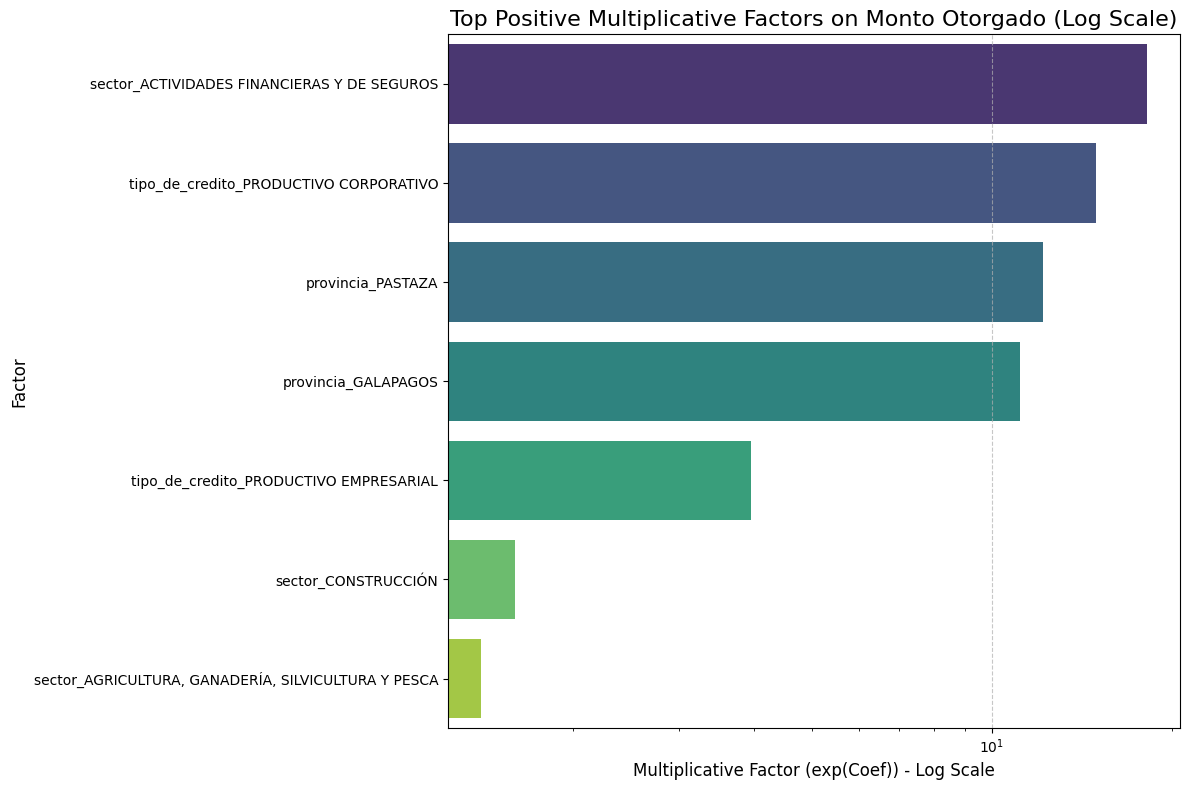

/tmp/ipython-input-3000557722.py:30: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Multiplicative Factor (exp(Coef))', y=negative_factors.index, data=negative_factors, palette='magma')


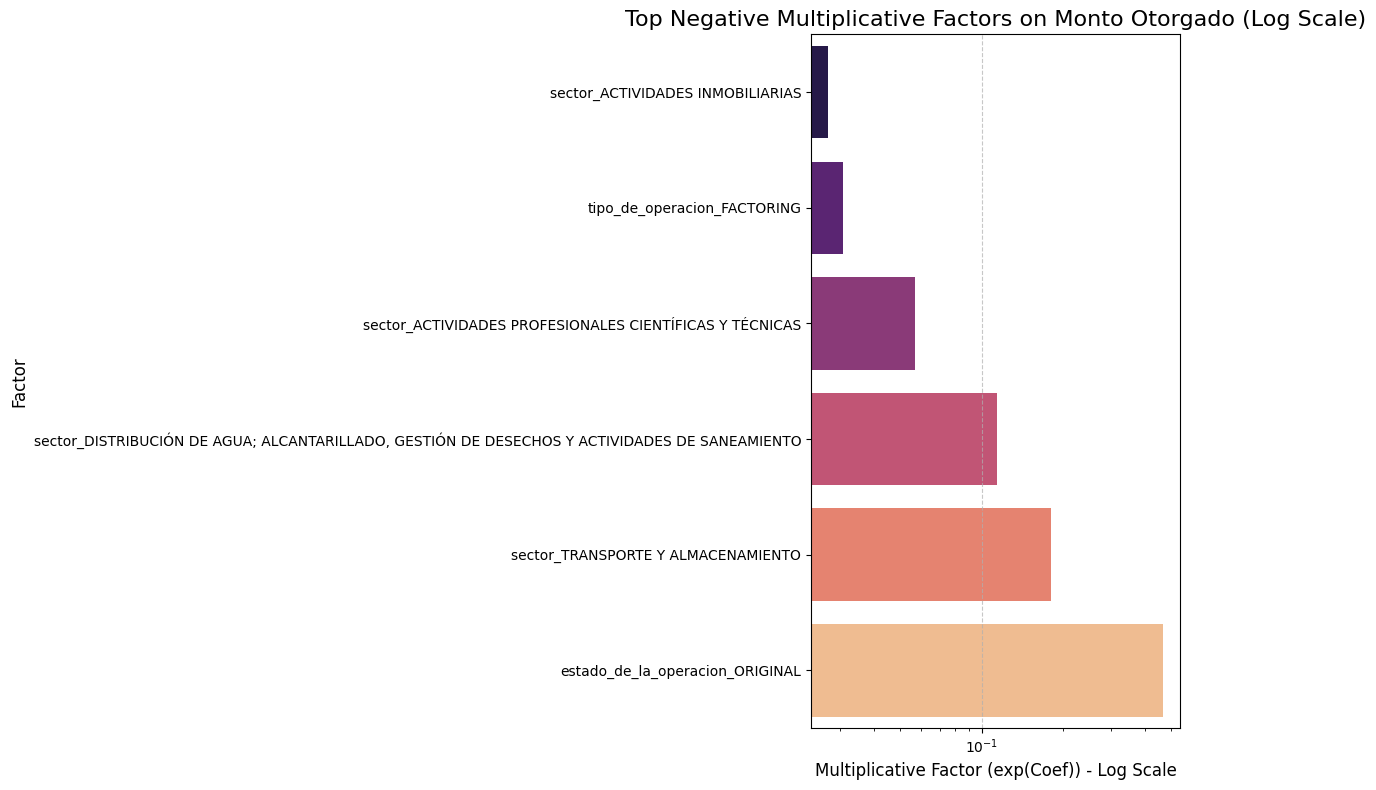

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Filter out 'const' and 'numero_de_operaciones' for clearer categorical visualization
plot_factors = significant_factors[~significant_factors.index.isin(['const', 'numero_de_operaciones'])]

# Separate positive and negative multiplicative factors
positive_factors = plot_factors[plot_factors['Multiplicative Factor (exp(Coef))'] > 1].sort_values(
    'Multiplicative Factor (exp(Coef))', ascending=False
)
negative_factors = plot_factors[plot_factors['Multiplicative Factor (exp(Coef))'] < 1].sort_values(
    'Multiplicative Factor (exp(Coef))', ascending=True
)

# Plotting Top Positive Multiplicative Factors
plt.figure(figsize=(12, 8))
sns.barplot(x='Multiplicative Factor (exp(Coef))', y=positive_factors.index, data=positive_factors, palette='viridis')
plt.xscale('log') # Use a log scale for better visualization of large differences
plt.title('Top Positive Multiplicative Factors on Monto Otorgado (Log Scale)', fontsize=16)
plt.xlabel('Multiplicative Factor (exp(Coef)) - Log Scale', fontsize=12)
plt.ylabel('Factor', fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Plotting Top Negative Multiplicative Factors
plt.figure(figsize=(12, 8))
sns.barplot(x='Multiplicative Factor (exp(Coef))', y=negative_factors.index, data=negative_factors, palette='magma')
plt.xscale('log') # Use a log scale for better visualization of large differences
plt.title('Top Negative Multiplicative Factors on Monto Otorgado (Log Scale)', fontsize=16)
plt.xlabel('Multiplicative Factor (exp(Coef)) - Log Scale', fontsize=12)
plt.ylabel('Factor', fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Task
To finalize the evaluation of the GLM model, calculate and visualize its residuals for diagnostic checks. Additionally, compute predictive accuracy metrics such as Mean Absolute Error (MAE) and Root Mean Squared Error (RMSE) to quantify the model's performance on the training data.

## Evaluate GLM Model

### Subtask:
Perform a comprehensive evaluation of the GLM model. This includes displaying goodness-of-fit statistics and coefficient significance using the model summary. It will also involve calculating and visualizing residuals for diagnostic checks and computing predictive accuracy metrics such as Mean Absolute Error (MAE) and Root Mean Squared Error (RMSE) to assess the model's performance on the training data.


**Reasoning**:
The first step in evaluating the GLM model is to display its full summary to get an overview of goodness-of-fit statistics and the significance of the coefficients. This is a crucial initial diagnostic check.



In [ ]:
print(glm_results.summary().as_text())

                 Generalized Linear Model Regression Results                  
Dep. Variable:         monto_otorgado   No. Observations:                  546
Model:                            GLM   Df Residuals:                      497
Model Family:                   Gamma   Df Model:                           48
Link Function:                    log   Scale:                         0.91206
Method:                          IRLS   Log-Likelihood:                -7575.3
Date:                Fri, 28 Nov 2025   Deviance:                       431.25
Time:                        20:56:15   Pearson chi2:                     453.
No. Iterations:                    48   Pseudo R-squ. (CS):             0.9763
Covariance Type:            nonrobust                                         
                                                                                                      coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------

**Reasoning**:
To further evaluate the GLM model, I will calculate the predicted values and Pearson residuals, then visualize their relationship to diagnose model fit. Additionally, I will compute MAE and RMSE to quantify predictive accuracy, covering the remaining evaluation steps outlined in the subtask.



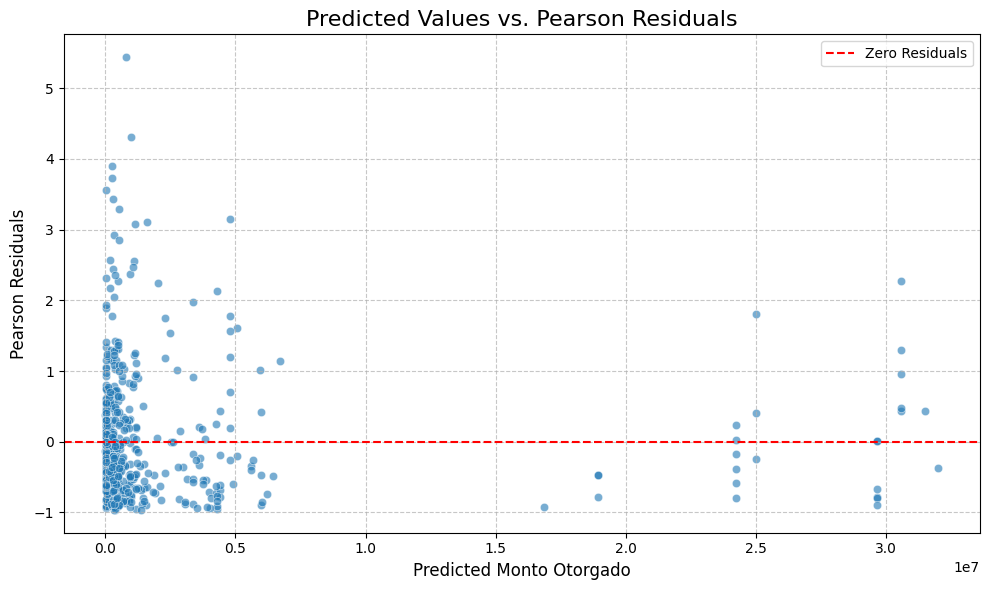


Mean Absolute Error (MAE): 1,464,778.74
Root Mean Squared Error (RMSE): 5,227,117.14


In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# 2. Calculate predicted values
y_pred = glm_results.predict(X)

# 3. Calculate Pearson residuals
pearson_residuals = glm_results.resid_pearson

# 4. Create a scatter plot of predicted values vs. Pearson residuals
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_pred, y=pearson_residuals, alpha=0.6)
plt.axhline(y=0, color='r', linestyle='--', label='Zero Residuals')
plt.title('Predicted Values vs. Pearson Residuals', fontsize=16)
plt.xlabel('Predicted Monto Otorgado', fontsize=12)
plt.ylabel('Pearson Residuals', fontsize=12)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# 6. Calculate Mean Absolute Error (MAE)
mae = mean_absolute_error(y, y_pred)

# 7. Calculate Root Mean Squared Error (RMSE)
rmse = np.sqrt(mean_squared_error(y, y_pred))

# 8. Print the calculated MAE and RMSE values
print(f"\nMean Absolute Error (MAE): {mae:,.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:,.2f}")

## Final Task

### Subtask:
Summarize the key findings from the GLM model evaluation, including its overall fit, the significance of coefficients, and its predictive accuracy. Discuss any insights gained and potential next steps for model improvement or application.


## Summary:

### Data Analysis Key Findings

*   The Generalized Linear Model (GLM) utilized a Gamma family with a log link function to predict `monto_otorgado`.
*   The model demonstrated a very strong fit to the training data, indicated by a Pseudo R-squared (CS) value of 0.9763, suggesting it explains a high proportion of the variance in `monto_otorgado`.
*   Several coefficients were statistically significant (p-values < 0.05), including `numero_de_operaciones`, `tipo_de_credito_PRODUCTIVO CORPORATIVO`, `tipo_de_operacion_FACTORING`, `estado_de_la_operacion_ORIGINAL`, and specific `provincia` and `sector` categories like `provincia_GALAPAGOS`, `provincia_PASTAZA`, `sector_ACTIVIDADES FINANCIERAS Y DE SEGUROS`, and `sector_CONSTRUCCIÓN`.
*   Conversely, many other `provincia` and `sector` coefficients did not show statistical significance at common alpha levels, implying their limited individual contribution to the model within this context.
*   The model's predictive accuracy on the training data was quantified with a Mean Absolute Error (MAE) of 1,464,778.74 and a Root Mean Squared Error (RMSE) of 5,227,117.14. These error magnitudes should be interpreted relative to the scale of the `monto_otorgado` variable.
*   Residual analysis involved a scatter plot of predicted values versus Pearson residuals, which is a key diagnostic tool to check for systematic errors and confirm a random distribution of residuals around zero.

### Insights or Next Steps

*   Given the high Pseudo R-squared, the model appears to capture the underlying relationships well within the training data. However, the high MAE and RMSE suggest that while the model explains a lot of variance, the absolute prediction errors can still be substantial, which is critical depending on the business context and the typical values of `monto_otorgado`.
*   To improve the model, consider exploring transformations or interactions for variables with non-significant coefficients, or re-evaluating the inclusion of less impactful predictors. Additionally, perform model validation on a separate test set to ensure generalizability and prevent overfitting, as the current evaluation is solely on training data.
